In [3]:
import pandas as pd
from test import convertCatToNum, drop_rows_with_missing, normalize, encode_player_names, split_data

# on import toutes les données

df_atp = pd.read_csv('all_matches_ATP.csv')

In [4]:
df_atp.columns

Index(['Court', 'Surface', 'Round', 'Player1_name', 'Player2_name',
       'Player1_rank', 'Player2_rank', 'Comment', 'Series', 'y'],
      dtype='object')

In [5]:

cat_cols = ['Court','Surface','Round'  ]

num_cols = ["Player1_rank","Player2_rank", "Series",]


In [6]:
import numpy as np


df_processed = convertCatToNum(df=df_atp,cat_cols=cat_cols)
df = drop_rows_with_missing(df_processed,columns=["y","Series"])
df_atp = normalize(df,num_cols)
df_final = encode_player_names(df=df_atp)

x_train, x_test, y_train, y_test = split_data(df_final)


 ===     Replace categorial variable     ===
 ===   Convert categorical to numerical  ===
 ===         drop missing values         ===
 ===            Normalize data           ===
=== Encoding player names ===
Encoding completed.
=== Splitting data into train and test sets ===
Data split completed.


In [7]:

X_train = x_train.drop(['Comment'],axis=1)
X_test = x_test.drop(['Comment'],axis=1)

In [8]:
nbr_test_valid = int(len(X_test)/2)

X_valid = X_test[:nbr_test_valid]
X_test = X_test[nbr_test_valid:]

y_valid = y_test[:nbr_test_valid]
y_test = y_test[nbr_test_valid:]



In [9]:
y_valid

44265    1
37191    1
26573    1
32841    1
46341    1
        ..
45481    1
13197    1
53061    0
23017    0
44889    1
Name: y, Length: 6899, dtype: int64

In [10]:
EPOCHS = 20

# CNN 1

In [11]:

from tensorflow.keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [12]:
# Build neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

In [13]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_valid, y_valid))


Epoch 1/20
876/876 [==============================] - 5s 5ms/step - loss: 1.1480 - accuracy: 0.4999 - val_loss: 0.8280 - val_accuracy: 0.5011
Epoch 2/20
876/876 [==============================] - 3s 4ms/step - loss: 0.9762 - accuracy: 0.5012 - val_loss: 0.9913 - val_accuracy: 0.4989
Epoch 3/20
876/876 [==============================] - 3s 3ms/step - loss: 0.9859 - accuracy: 0.5041 - val_loss: 0.7097 - val_accuracy: 0.5143
Epoch 4/20
876/876 [==============================] - 3s 4ms/step - loss: 0.8685 - accuracy: 0.5041 - val_loss: 0.6927 - val_accuracy: 0.5212
Epoch 5/20
876/876 [==============================] - 3s 4ms/step - loss: 0.8929 - accuracy: 0.5100 - val_loss: 0.7740 - val_accuracy: 0.5070
Epoch 6/20
876/876 [==============================] - 3s 3ms/step - loss: 0.8473 - accuracy: 0.5088 - val_loss: 0.7480 - val_accuracy: 0.5136
Epoch 7/20
876/876 [==============================] - 3s 3ms/step - loss: 0.8397 - accuracy: 0.5100 - val_loss: 0.7681 - val_accuracy: 0.5036
Epoch 

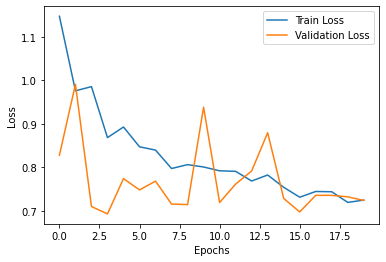

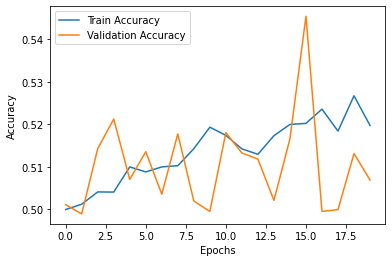

In [15]:

import matplotlib.pyplot as plt
# Afficher les courbes de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Afficher les courbes de précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

216/216 [==============================] - 1s 2ms/step - loss: 0.7189 - accuracy: 0.5098
Test Accuracy: 0.5097840428352356


# CNN

In [17]:
X_train

,Player1_rank,Player2_rank,Series,Court_Indoor,Court_Outdoor,Surface_Carpet,Surface_Clay,Surface_Grass,Surface_Hard,Round_1st Round,Round_2nd Round,Round_3rd Round,Round_4th Round,Round_Quarterfinals,Round_Round Robin,Round_Semifinals,Round_The Final,Player1_name_encoded,Player2_name_encoded
56168,0.031268,0.012004,0.428571,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1167,1120
28740,0.022419,0.007528,0.428571,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1131,129
27384,0.065192,0.003052,0.428571,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1291,1186
23831,0.033628,0.018718,0.000000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,718,750
43928,0.006195,0.009563,0.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,1,652,488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22636,0.015929,0.018922,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1309,1131
27655,0.000590,0.000203,1.000000,0,1,0,0,0,1,0,0,0,0,0,0,0,1,845,292
54529,0.013864,0.005493,0.000000,0,1,0,1,0,0,1,0,0,0,0,0,0,0,454,1018
4563,0.025959,0.000203,1.000000,0,1,0,0,1,0,0,1,0,0,0,0,0,0,169,4


In [18]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification



In [19]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                      

In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/20


876/876 [==============================] - 8s 7ms/step - loss: 0.7623 - accuracy: 0.4980 - val_loss: 0.8077 - val_accuracy: 0.5036
Epoch 2/20
876/876 [==============================] - 5s 6ms/step - loss: 0.7093 - accuracy: 0.5016 - val_loss: 0.6959 - val_accuracy: 0.5072
Epoch 3/20
876/876 [==============================] - 5s 6ms/step - loss: 0.6982 - accuracy: 0.5048 - val_loss: 0.6980 - val_accuracy: 0.4966
Epoch 4/20
876/876 [==============================] - 6s 7ms/step - loss: 0.6973 - accuracy: 0.5031 - val_loss: 0.6932 - val_accuracy: 0.5053
Epoch 5/20
876/876 [==============================] - 6s 7ms/step - loss: 0.6930 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4954
Epoch 6/20
876/876 [==============================] - 5s 6ms/step - loss: 0.6928 - accuracy: 0.5062 - val_loss: 0.6930 - val_accuracy: 0.4963
Epoch 7/20
876/876 [==============================] - 5s 6ms/step - loss: 0.6927 - accuracy: 0.5053 - val_loss: 0.6936 - val_accuracy: 0.4959
Epoch 8/20
876/87

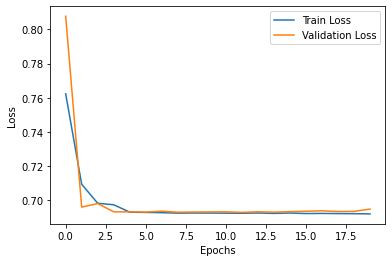

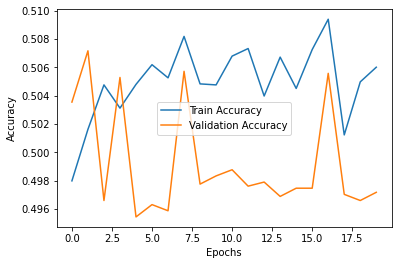

In [22]:
# Afficher les courbes de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Afficher les courbes de précision
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

216/216 [==============================] - 0s 2ms/step - loss: 0.6944 - accuracy: 0.4938
Test Accuracy: 0.49383968114852905
